# Transfer learning with MobileNetv2

## Imports and definations

### Imports

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, random_split

import torchvision

from pathlib import Path

from matplotlib import pyplot as plt

### Functions

In [2]:
def train(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: str = 'cuda', tensorboard_writer=None, epoch:int=0):
    running_loss = 0
    i_c = 0
    number_of_batches = len(data_loader)
    model.train()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        prediction = model(images)
        loss = loss_fn(prediction, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i_c += 1
        if (i % 10 == 9) or i == number_of_batches-1:
            print(f'\r{i+1}/{number_of_batches}, loss = {loss.item():>4f}',end='')
            if tensorboard_writer:

                tensorboard_writer.add_scalar('training loss',
                                running_loss / i_c ,
                                epoch * number_of_batches + i)
            running_loss = 0
            i_c = 0
    print()

In [3]:
def test(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, device:str='cuda') -> tuple[torch.float, torch.float]:
    data_size = len(data_loader.dataset)
    number_of_batches = len(data_loader)

    model.eval()

    loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            prediction = model(images)
            loss += loss_fn(prediction, labels).item()
            correct += (prediction.argmax(1) ==
                        labels).type(torch.float).sum().item()

        loss /= number_of_batches
        correct /= data_size

    return correct, loss

## Run

### Tensorboard

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fruits_100')

In [9]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 18527), started 0:01:19 ago. (Use '!kill 18527' to kill it.)

### Device

In [6]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

print(f'device: {device}')

device: cuda


### get data

#### In pc

In [7]:
data_path = Path('/home/ramin/ramin_programs/files/datasets/fruits-100')

#### In colab

In [ ]:
from google.colab import userdata

In [ ]:
kaggle_target_path = Path('/root/.kaggle/kaggle.json')

kaggle_target_path.parent.mkdir(exist_ok=True, parents=True)

with open(kaggle_target_path,'w') as f:
  f.write(userdata.get('Kaggle'))

In [ ]:
! kaggle datasets download -d marquis03/fruits-100

100% 433M/435M [00:22<00:00, 22.9MB/s]
100% 435M/435M [00:22<00:00, 20.1MB/s]


In [ ]:
! unzip -q fruits-100.zip -d fruits-100

In [ ]:
! rm -r fruits-100.zip

In [ ]:
data_path = Path('fruits-100')

## load data

In [11]:
train_data_path = data_path / 'train'
valid_data_path = data_path / 'val'
test_data_path = data_path / 'test'

In [12]:
tr = torchvision.transforms.Compose(
    [torchvision.transforms.Resize([90,160]),torchvision.transforms.ToTensor(),]
)

train_image_folder = torchvision.datasets.ImageFolder(train_data_path, transform=tr)
valid_image_folder = torchvision.datasets.ImageFolder(valid_data_path, transform=tr)
test_image_folder = torchvision.datasets.ImageFolder(test_data_path, transform=tr)

In [13]:
train_data_loader = DataLoader(train_image_folder, batch_size=32, shuffle=True)
val_data_loader = DataLoader(valid_image_folder, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_image_folder, batch_size=32, shuffle=True)

tensor(80)


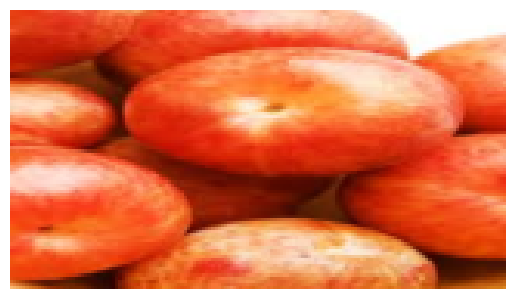

In [14]:
for tensor_image, label in train_data_loader:
    figure, axes = plt.subplots(1,1)

    axes.imshow(torchvision.transforms.ToPILImage()(tensor_image[0]))
    axes.set_axis_off()
    print(label[0])
    break

## Define model

In [15]:
model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V1)

In [16]:
model.classifier[1] = nn.Linear(1280, 100)

In [17]:
model = model.to(device)

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Train the model

In [19]:
for epoch in range(5):
    print(f'in epoch: {epoch}')
    train(model, train_data_loader, loss_fn,
          optimizer, device, writer, epoch)
    accuracy, loss = test(model, val_data_loader, loss_fn, device)
    print(f'accuracy: {accuracy:.2f}, loss: {loss:.2f}')

in epoch: 0
1250/1250, loss = 1.949642
accuracy: 0.45, loss: 1.95
in epoch: 1
1250/1250, loss = 1.389946
accuracy: 0.56, loss: 1.56
in epoch: 2
1250/1250, loss = 1.694923
accuracy: 0.59, loss: 1.46
in epoch: 3
1250/1250, loss = 0.974778
accuracy: 0.62, loss: 1.32
in epoch: 4
1250/1250, loss = 0.934104
accuracy: 0.63, loss: 1.27


In [20]:
accuracy, loss = test(model, test_data_loader, loss_fn, device)
print('test results:')
print(f'accuracy: {accuracy}, loss: {loss}')

test results:
accuracy: 0.0052, loss: 12.861438988120693
